#google colab prep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U pip setuptools
!pip uninstall --yes --quiet osqp
!pip install scikit-survival

  Using cached osqp-0.6.2.post0-cp37-cp37m-manylinux2014_x86_64.whl (212 kB)


#Importing data & Data processing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sksurv.nonparametric import kaplan_meier_estimator


In [ ]:
#input data
missing_values=["[Not Applicable]","[Unknown]","[unknown]","[Not Available]","[Not Evaluated]"]

data_markNA = pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/brca_clinical_data.csv", na_values=missing_values)
data_initial = pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/brca_clinical_data.csv")
data_initial = data_initial.drop([0,1])
data_markNA = data_markNA.drop([0,1])

#drop males 

data_initial = data_initial[data_initial['gender']!="MALE"]
data_markNA = data_markNA[data_markNA['gender']!="MALE"]


In [ ]:
#input parameters 
all_param = pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/selected_features.csv")

def map_name(original_name):
    helper_list=original_name.split(' ')
    return helper_list[1]

all_param = all_param['Column'].dropna()

all_param= all_param.apply(map_name)

# data_dropNA:missing values as NaN to be dropped
data = data_initial
data_selected_features = data_initial[all_param]
data_selected_features['bcr_patient_uuid'] = data_initial['bcr_patient_uuid']
data_selected_features['bcr_patient_barcode'] = data_initial['bcr_patient_barcode']
data_dropNA = data_markNA[all_param]


#features included by accident 
mistake_features=["surgery_for_positive_margins",
                  "surgery_for_positive_margins_other","margin_status_reexcision",
                  "micromet_detection_by_ihc",
                  'lymph_nodes_examined_count','lymph_nodes_examined_he_count']
#drop mistake features
data = data.drop(axis=1, columns=mistake_features)
data_dropNA = data_dropNA.drop(axis=1, columns=mistake_features)
data_selected_features = data_selected_features.drop(axis=1, columns=mistake_features)

#correct days to death: not applicable --> infinity 
data_dropNA["death_days_to"]=data_dropNA["death_days_to"].fillna(float('inf'))

data_imp = data_selected_features



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
data_imp.loc[data_imp["death_days_to"] == '[Not Applicable]', 'death_days_to'] = np.NAN
data_imp["death_days_to"]=data_imp["death_days_to"].fillna(float("inf"))

data: represent the whole table as imported with unwnated features droped 
data_selected_features: represent the whole table as imported with only selected features 
data_imp: all the missing values imputed 

In [ ]:
#drop all na # Not used anymore due to the drastic reduction in sample size 
data_drop_all_na = data_dropNA.dropna(axis=0)
data_drop_all_na

,menopause_status,race,history_other_malignancy,tumor_status,vital_status,last_contact_days_to,death_days_to,age_at_diagnosis,surgical_procedure_first,margin_status,ajcc_tumor_pathologic_pt,ajcc_nodes_pathologic_pn,ajcc_metastasis_pathologic_pm,ajcc_pathologic_tumor_stage,er_status_by_ihc,pr_status_by_ihc,her2_status_by_ihc,anatomic_neoplasm_subdivision,histological_type,icd_o_3_histology
2,Pre (<6 months since LMP AND no prior bilatera...,WHITE,No,WITH TUMOR,Alive,3767,inf,55,Modified Radical Mastectomy,Negative,TX,NX,MX,Stage X,Positive,Positive,Negative,Left Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3
3,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,No,TUMOR FREE,Alive,3801,inf,50,Lumpectomy,Negative,T2,N1a,M0,Stage IIB,Positive,Positive,Positive,Right Upper Outer Quadrant,Infiltrating Ductal Carcinoma,8500/3
4,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,No,TUMOR FREE,Alive,1228,inf,62,Modified Radical Mastectomy,Negative,T2,N1a,M0,Stage IIB,Positive,Positive,Indeterminate,Right,Infiltrating Ductal Carcinoma,8500/3
6,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,No,TUMOR FREE,Alive,158,inf,50,Modified Radical Mastectomy,Negative,T2,N2a,M0,Stage IIIA,Positive,Positive,Equivocal,Left|Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3
7,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,Yes,TUMOR FREE,Alive,1477,inf,42,Modified Radical Mastectomy,Positive,T2,N0,M0,Stage IIA,Positive,Positive,Negative,Right|Right Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,No,TUMOR FREE,Alive,791,inf,77,Lumpectomy,Negative,T1c,N0 (i-),MX,Stage IA,Positive,Positive,Negative,Left,Infiltrating Lobular Carcinoma,8520/3
1095,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,No,TUMOR FREE,Alive,292,inf,46,Modified Radical Mastectomy,Negative,T1c,N2a,MX,Stage IIIA,Positive,Positive,Negative,Right Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3
1096,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,No,TUMOR FREE,Alive,278,inf,68,Simple Mastectomy,Negative,T3,N0,MX,Stage IIB,Positive,Positive,Negative,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3
1097,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,Yes,TUMOR FREE,Alive,3042,inf,61,Other,Positive,T3,N1a,MX,Stage IIIA,Positive,Positive,Negative,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3


In [ ]:
data_dropNA.isna().sum()

menopause_status                  78
race                              94
history_other_malignancy           0
tumor_status                     124
vital_status                       0
last_contact_days_to             104
death_days_to                      0
age_at_diagnosis                   0
surgical_procedure_first          54
margin_status                     68
ajcc_tumor_pathologic_pt           0
ajcc_nodes_pathologic_pn           0
ajcc_metastasis_pathologic_pm      0
ajcc_pathologic_tumor_stage        5
er_status_by_ihc                  49
pr_status_by_ihc                  50
her2_status_by_ihc               176
anatomic_neoplasm_subdivision      0
histological_type                  1
icd_o_3_histology                  0
dtype: int64

In [ ]:
#prep for fill menopause status
data["menopause_status"].unique()
data["menopause_status"].value_counts()
# generate for [Not Available],[Unknown], [Not Evaluated]

#data["age_at_diagnosis"] = pd.to_numeric(data["age_at_diagnosis"])
#data[["menopause_status","age_at_diagnosis"]].groupby(["menopause_status"]).mean()

Post (prior bilateral ovariectomy OR >12 mo since LMP with no prior hysterectomy)               705
Pre (<6 months since LMP AND no prior bilateral ovariectomy AND not on estrogen replacement)    229
[Not Available]                                                                                  56
Peri (6-12 months since last menstrual period)                                                   39
Indeterminate (neither Pre or Postmenopausal)                                                    34
[Unknown]                                                                                        17
[Not Evaluated]                                                                                   5
Name: menopause_status, dtype: int64

In [ ]:
#fill menopause 

# clean the data and mark the NaN
data.loc[data["menopause_status"] == '[Not Available]', "menopause_status"] = np.NAN
data.loc[data["menopause_status"] == '[Unknown]', "menopause_status"] = np.NAN
data.loc[data["menopause_status"] == '[Not Evaluated]', "menopause_status"] = np.NAN
data['menopause_status'].isna().sum()

# sub data frame with just the variables of interest
df=data[['menopause_status', 'age_at_diagnosis']]
missing_meno=data['menopause_status'].isnull()

# extract the age for the missing menopause data patients 
age_mis_meno = pd.DataFrame(df['age_at_diagnosis'][missing_meno])

# prep for training data 
meno_st=data["menopause_status"].dropna()

# turn into numeric data
def map_meno(input_status):
    helper_list=input_status.split(' ')
    if (helper_list[0]=="Pre"):
        return 1
    elif (helper_list[0]=="Peri"):
        return 2
    elif (helper_list[0]=="Indeterminate"):
        return 3
    else:
        return 4

meno_st=meno_st.apply(map_meno)
df["menopause_status"]=meno_st

# regression model and prediction
df=df.dropna()
X=df[['age_at_diagnosis']]
y=df[['menopause_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lm = LinearRegression().fit(X_train, y_train)
meno_pred = lm.predict(age_mis_meno)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# processing the prediction
age_mis_meno['meno_status_imputed']=meno_pred.round()

# merging the table
age_mis_meno.rename(columns={'age_at_diagnosis':'age_for_mis_meno'},inplace=True)

final_df = pd.concat([df, age_mis_meno], axis=1)
final_df['menopause_status_imputed'] = np.where(final_df['menopause_status'].isnull(), final_df['meno_status_imputed'],final_df['menopause_status'])
final_df['age_at_diagnosis'] = np.where(final_df['age_at_diagnosis'].isnull(), final_df['age_for_mis_meno'],final_df['age_at_diagnosis'])
final_df = final_df[['age_at_diagnosis','menopause_status_imputed']]

data_1 = data
data_1['menopause_status_imputed'] = final_df['menopause_status_imputed']
data_1.drop(columns=['menopause_status'], inplace=True)

# data_1 contains all the original data with an aditional column of menopause_status_imputed
data_1
#data_selected_features_1 contains all the selected features and imputed conlumns

data_imp['menopause_status_imputed'] = final_df['menopause_status_imputed']

data_imp['menopause_status_imputed'].value_counts()



4.0    715
1.0    232
2.0     68
3.0     65
5.0      5
Name: menopause_status_imputed, dtype: int64

In [ ]:
#imputing for race, tumor_status, er_status_by_ihc, pr_status_by_ihc, her2_status_by_ihc via probablistic model 

#prep race
data["race"].unique()
data["race"].value_counts()


WHITE                               749
BLACK OR AFRICAN AMERICAN           180
[Not Available]                      91
ASIAN                                61
[Not Evaluated]                       3
AMERICAN INDIAN OR ALASKA NATIVE      1
Name: race, dtype: int64

In [ ]:
# mark and fill NA 
data_imp.loc[data_imp["race"] == '[Not Available]', "race"] = np.NAN
data_imp.loc[data_imp["race"] == '[Not Evaluated]', "race"] = np.NAN

def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imputed'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df


data_imp['race_imputed'] = data_imp['race']
data_imp = random_imputation(data_imp, 'race')

In [ ]:
#prep tumor_status
data["tumor_status"].unique()
data["tumor_status"].value_counts()

TUMOR FREE         868
[Not Available]    104
WITH TUMOR          93
[Unknown]           20
Name: tumor_status, dtype: int64

In [ ]:
#filling in missing values for tumor status 
data_imp.loc[data_imp["tumor_status"] == '[Not Available]', "tumor_status"] = np.NAN
data_imp.loc[data_imp["tumor_status"] == '[Unknown]', "tumor_status"] = np.NAN

def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imputed'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df


data_imp['tumor_status_imputed'] = data_imp['tumor_status']
data_imp = random_imputation(data_imp, 'tumor_status')


In [ ]:
#prep er_status_by_ihc
data["er_status_by_ihc"].unique()
data["er_status_by_ihc"].value_counts()

Positive           796
Negative           238
[Not Evaluated]     49
Indeterminate        2
Name: er_status_by_ihc, dtype: int64

In [ ]:
#filling in missing values for er_status_by_ihc
data_imp.loc[data_imp["er_status_by_ihc"] == '[Not Evaluated]', "er_status_by_ihc"] = np.NAN


def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imputed'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

data_imp['er_status_by_ihc_imputed'] = data_imp['er_status_by_ihc']
data_imp = random_imputation(data_imp, 'er_status_by_ihc')


In [ ]:
#prep pr_status_by_ihc
data["pr_status_by_ihc"].unique()
data["pr_status_by_ihc"].value_counts()

Positive           689
Negative           342
[Not Evaluated]     50
Indeterminate        4
Name: pr_status_by_ihc, dtype: int64

In [ ]:
#filling in missing values for pr_status_by_ihc
data_imp.loc[data_imp["pr_status_by_ihc"] == '[Not Evaluated]', "pr_status_by_ihc"] = np.NAN


def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imputed'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

data_imp['pr_status_by_ihc_imputed'] = data_imp['pr_status_by_ihc']
data_imp = random_imputation(data_imp, 'pr_status_by_ihc')
data_imp['pr_status_by_ihc_imputed'].value_counts()

Positive         729
Negative         352
Indeterminate      4
Name: pr_status_by_ihc_imputed, dtype: int64

In [ ]:
#prep her2_status_by_ihc
data["her2_status_by_ihc"].unique()
data["her2_status_by_ihc"].value_counts()

Negative           559
Equivocal          177
[Not Evaluated]    168
Positive           161
Indeterminate       12
[Not Available]      8
Name: her2_status_by_ihc, dtype: int64

In [ ]:
#filling in missing values for her2_status_by_ihc
data_imp.loc[data_imp["her2_status_by_ihc"] == '[Not Evaluated]', "her2_status_by_ihc"] = np.NAN
data_imp.loc[data_imp["her2_status_by_ihc"] == '[Not Available]', "her2_status_by_ihc"] = np.NAN

def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imputed'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

data_imp['her2_status_by_ihc_imputed'] = data_imp['her2_status_by_ihc']
data_imp = random_imputation(data_imp, 'her2_status_by_ihc')


In [ ]:
imputed_columns = ['menopause_status','race','tumor_status','er_status_by_ihc','pr_status_by_ihc','her2_status_by_ihc']
data_imp.drop(columns=imputed_columns, inplace=True)


In [ ]:
# fill na and drop rows
data_imp.loc[data_imp["surgical_procedure_first"] == '[Not Available]', "surgical_procedure_first"] = np.NAN
data_imp.loc[data_imp["surgical_procedure_first"] == '[Unknown]', "surgical_procedure_first"] = np.NAN
data_imp.loc[data_imp["surgical_procedure_first"] == '[Discrepancy]', "surgical_procedure_first"] = np.NAN
data_imp.loc[data_imp["margin_status"] == '[Not Available]', "margin_status"] = np.NAN
data_imp.loc[data_imp["margin_status"] == '[Unknown]', "margin_status"] = np.NAN
data_imp.loc[data_imp["ajcc_pathologic_tumor_stage"] == '[Discrepancy]', "ajcc_pathologic_tumor_stage"] = np.NAN
data_imp.loc[data_imp["ajcc_pathologic_tumor_stage"] == '[Not Available]', "ajcc_pathologic_tumor_stage"] = np.NAN
data_imp.loc[data_imp["histological_type"] == '[Not Available]', "histological_type"] = np.NAN
data_imp.loc[data_imp["history_other_malignancy"] == '[Discrepancy]', "history_other_malignancy"] = np.NAN

In [ ]:
#drop rows "surgical_procedure_first", "margin_status","ajcc_pathologic_tumor_stage","histological_type"
data_imp.dropna(axis=0, inplace=True)
data_imp

,history_other_malignancy,vital_status,last_contact_days_to,death_days_to,age_at_diagnosis,surgical_procedure_first,margin_status,ajcc_tumor_pathologic_pt,ajcc_nodes_pathologic_pn,ajcc_metastasis_pathologic_pm,ajcc_pathologic_tumor_stage,anatomic_neoplasm_subdivision,histological_type,icd_o_3_histology,bcr_patient_uuid,bcr_patient_barcode,menopause_status_imputed,race_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed
2,No,Alive,3767,inf,55,Modified Radical Mastectomy,Negative,TX,NX,MX,Stage X,Left Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6E7D5EC6-A469-467C-B748-237353C23416,TCGA-3C-AAAU,1.0,WHITE,WITH TUMOR,Positive,Positive,Negative
3,No,Alive,3801,inf,50,Lumpectomy,Negative,T2,N1a,M0,Stage IIB,Right Upper Outer Quadrant,Infiltrating Ductal Carcinoma,8500/3,55262FCB-1B01-4480-B322-36570430C917,TCGA-3C-AALI,4.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Positive
4,No,Alive,1228,inf,62,Modified Radical Mastectomy,Negative,T2,N1a,M0,Stage IIB,Right,Infiltrating Ductal Carcinoma,8500/3,427D0648-3F77-4FFC-B52C-89855426D647,TCGA-3C-AALJ,4.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Indeterminate
5,No,Alive,1217,inf,52,Simple Mastectomy,Close,T1c,N0 (i+),M0,Stage IA,Right,Infiltrating Ductal Carcinoma,8500/3,C31900A4-5DCD-4022-97AC-638E86E889E4,TCGA-3C-AALK,3.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Positive
6,No,Alive,158,inf,50,Modified Radical Mastectomy,Negative,T2,N2a,M0,Stage IIIA,Left|Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6623FC5E-00BE-4476-967A-CBD55F676EA6,TCGA-4H-AAAK,4.0,WHITE,TUMOR FREE,Positive,Positive,Equivocal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,No,Alive,791,inf,77,Lumpectomy,Negative,T1c,N0 (i-),MX,Stage IA,Left,Infiltrating Lobular Carcinoma,8520/3,5CD79093-1571-4F71-8136-0D84CCABDCAC,TCGA-WT-AB44,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative
1095,No,Alive,292,inf,46,Modified Radical Mastectomy,Negative,T1c,N2a,MX,Stage IIIA,Right Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,F89588E9-CA73-4465-A7FB-7246EDB45E3A,TCGA-XX-A899,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative
1096,No,Alive,278,inf,68,Simple Mastectomy,Negative,T3,N0,MX,Stage IIB,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,TCGA-XX-A89A,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative
1097,Yes,Alive,3042,inf,61,Other,Positive,T3,N1a,MX,Stage IIIA,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,TCGA-Z7-A8R5,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative


In [ ]:
data_imp['ajcc_pathologic_tumor_stage'].value_counts()

Stage IIA     321
Stage IIB     231
Stage IIIA    137
Stage I        84
Stage IA       78
Stage IIIC     59
Stage IIIB     20
Stage IV       16
Stage X         8
Stage IB        7
Stage II        4
Stage III       2
Name: ajcc_pathologic_tumor_stage, dtype: int64

In [ ]:
def map_stage(input_status):
    helper_list=input_status.split(' ')
    if (helper_list[1]=='I'): return 1.5
    if (helper_list[1]=='IA'): return 1
    if (helper_list[1]=='IB'): return 2
    if (helper_list[1]=='II'): return 3.5
    if (helper_list[1]=='IIA'): return 3
    if (helper_list[1]=='IIB'): return 4
    if (helper_list[1]=='III'): return 6
    if (helper_list[1]=='IIIA'): return 5
    if (helper_list[1]=='IIIB'): return 6
    if (helper_list[1]=='IIIC'): return 7
    if (helper_list[1]=='IV'): return 8
    if (helper_list[1]=='X'): return 0

   
tumor_st=data_imp['ajcc_pathologic_tumor_stage']
tumor_st=tumor_st.apply(map_stage)
data_imp["tumor_stage"]=tumor_st
data_imp.drop(columns='ajcc_pathologic_tumor_stage',inplace=True)



In [ ]:
data_imp["tumor_stage"].value_counts()

3.0    321
4.0    231
5.0    137
1.5     84
1.0     78
7.0     59
6.0     22
8.0     16
0.0      8
2.0      7
3.5      4
Name: tumor_stage, dtype: int64

In [ ]:
saved_data_imp=data_imp

In [ ]:
def map_hist(input_status):
    helper_list=input_status.split(' ')
    if (input_status=='No'):
      return 0
    else: #"yes"
      return 1

data_imp['history_other_malignancy']=data_imp['history_other_malignancy'].apply(map_hist)


In [ ]:
def map_marginst(input_status):
    helper_list=input_status.split(' ')
    if (input_status=='Negative'):
      return 0
    elif (input_status=='Positive'):
      return 2
    else:#"close"
      return 1

data_imp['margin_status']=data_imp['margin_status'].apply(map_marginst)

In [ ]:
def map_pt(input_status):
  if(input_status=='T1b'): return 1;
  if(input_status=='T1c'): return 2;
  if(input_status=='T1'): return 1.5;
  if(input_status=='T2a'): return 3;
  if(input_status=='T2b'): return 4;
  if(input_status=='T2'): return 3.5;
  if(input_status=='T3a'): return 5;
  if(input_status=='T3'): return 5.5;
  if(input_status=='T4b'): return 6;
  if(input_status=='T4d'): return 7;
  if(input_status=='T4'): return 6.5;
  if(input_status=='TX'): return 0.5;

data_imp['pt']=data_imp['ajcc_tumor_pathologic_pt'].apply(map_pt)
data_imp.drop(['ajcc_tumor_pathologic_pt'], axis=1)
#

,history_other_malignancy,vital_status,last_contact_days_to,death_days_to,age_at_diagnosis,surgical_procedure_first,margin_status,ajcc_nodes_pathologic_pn,ajcc_metastasis_pathologic_pm,anatomic_neoplasm_subdivision,histological_type,icd_o_3_histology,bcr_patient_uuid,bcr_patient_barcode,menopause_status_imputed,race_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt
2,0,Alive,3767,inf,55,Modified Radical Mastectomy,0,NX,MX,Left Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6E7D5EC6-A469-467C-B748-237353C23416,TCGA-3C-AAAU,1.0,WHITE,WITH TUMOR,Positive,Positive,Negative,0.0,0.5
3,0,Alive,3801,inf,50,Lumpectomy,0,N1a,M0,Right Upper Outer Quadrant,Infiltrating Ductal Carcinoma,8500/3,55262FCB-1B01-4480-B322-36570430C917,TCGA-3C-AALI,4.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Positive,4.0,3.5
4,0,Alive,1228,inf,62,Modified Radical Mastectomy,0,N1a,M0,Right,Infiltrating Ductal Carcinoma,8500/3,427D0648-3F77-4FFC-B52C-89855426D647,TCGA-3C-AALJ,4.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Indeterminate,4.0,3.5
5,0,Alive,1217,inf,52,Simple Mastectomy,1,N0 (i+),M0,Right,Infiltrating Ductal Carcinoma,8500/3,C31900A4-5DCD-4022-97AC-638E86E889E4,TCGA-3C-AALK,3.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Positive,1.0,2.0
6,0,Alive,158,inf,50,Modified Radical Mastectomy,0,N2a,M0,Left|Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6623FC5E-00BE-4476-967A-CBD55F676EA6,TCGA-4H-AAAK,4.0,WHITE,TUMOR FREE,Positive,Positive,Equivocal,5.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,0,Alive,791,inf,77,Lumpectomy,0,N0 (i-),MX,Left,Infiltrating Lobular Carcinoma,8520/3,5CD79093-1571-4F71-8136-0D84CCABDCAC,TCGA-WT-AB44,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,1.0,2.0
1095,0,Alive,292,inf,46,Modified Radical Mastectomy,0,N2a,MX,Right Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,F89588E9-CA73-4465-A7FB-7246EDB45E3A,TCGA-XX-A899,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,5.0,2.0
1096,0,Alive,278,inf,68,Simple Mastectomy,0,N0,MX,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,TCGA-XX-A89A,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,4.0,5.5
1097,1,Alive,3042,inf,61,Other,2,N1a,MX,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,TCGA-Z7-A8R5,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,5.0,5.5


In [ ]:
def map_pn(input_status):
    helper_list=input_status.split(' ')
    if (helper_list[0]=='N0'): return 0
    if (helper_list[0]=='N1a'): return 1
    if (helper_list[0]=='N1b'): return 2
    if (helper_list[0]=='N1'): return 2
    if (helper_list[0]=='N1mi'): return 2
    if (helper_list[0]=='N1c'): return 3
    if (helper_list[0]=='N2a'): return 4
    if (helper_list[0]=='N2'): return 4.5
    if (helper_list[0]=='N3'): return 6
    if (helper_list[0]=='N3a'): return 5
    if (helper_list[0]=='N3b'): return 6
    if (helper_list[0]=='N3c'): return 7
    if (helper_list[0]=='NX'): return 0.5

data_imp['pn']=data_imp['ajcc_nodes_pathologic_pn'].apply(map_pn)
data_imp.drop(['ajcc_nodes_pathologic_pn'], axis=1)
#

,history_other_malignancy,vital_status,last_contact_days_to,death_days_to,age_at_diagnosis,surgical_procedure_first,margin_status,ajcc_tumor_pathologic_pt,ajcc_metastasis_pathologic_pm,anatomic_neoplasm_subdivision,histological_type,icd_o_3_histology,bcr_patient_uuid,bcr_patient_barcode,menopause_status_imputed,race_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt,pn
2,0,Alive,3767,inf,55,Modified Radical Mastectomy,0,TX,MX,Left Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6E7D5EC6-A469-467C-B748-237353C23416,TCGA-3C-AAAU,1.0,WHITE,WITH TUMOR,Positive,Positive,Negative,0.0,0.5,0.5
3,0,Alive,3801,inf,50,Lumpectomy,0,T2,M0,Right Upper Outer Quadrant,Infiltrating Ductal Carcinoma,8500/3,55262FCB-1B01-4480-B322-36570430C917,TCGA-3C-AALI,4.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Positive,4.0,3.5,1.0
4,0,Alive,1228,inf,62,Modified Radical Mastectomy,0,T2,M0,Right,Infiltrating Ductal Carcinoma,8500/3,427D0648-3F77-4FFC-B52C-89855426D647,TCGA-3C-AALJ,4.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Indeterminate,4.0,3.5,1.0
5,0,Alive,1217,inf,52,Simple Mastectomy,1,T1c,M0,Right,Infiltrating Ductal Carcinoma,8500/3,C31900A4-5DCD-4022-97AC-638E86E889E4,TCGA-3C-AALK,3.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Positive,1.0,2.0,0.0
6,0,Alive,158,inf,50,Modified Radical Mastectomy,0,T2,M0,Left|Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6623FC5E-00BE-4476-967A-CBD55F676EA6,TCGA-4H-AAAK,4.0,WHITE,TUMOR FREE,Positive,Positive,Equivocal,5.0,3.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,0,Alive,791,inf,77,Lumpectomy,0,T1c,MX,Left,Infiltrating Lobular Carcinoma,8520/3,5CD79093-1571-4F71-8136-0D84CCABDCAC,TCGA-WT-AB44,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,1.0,2.0,0.0
1095,0,Alive,292,inf,46,Modified Radical Mastectomy,0,T1c,MX,Right Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,F89588E9-CA73-4465-A7FB-7246EDB45E3A,TCGA-XX-A899,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,5.0,2.0,4.0
1096,0,Alive,278,inf,68,Simple Mastectomy,0,T3,MX,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,TCGA-XX-A89A,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,4.0,5.5,0.0
1097,1,Alive,3042,inf,61,Other,2,T3,MX,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,TCGA-Z7-A8R5,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,5.0,5.5,1.0


In [ ]:
def map_pm(input_status):
    helper_list=input_status.split(' ')
    if (helper_list[0]=='M0'): return 0
    if (helper_list[0]=='M1'): return 1
    if (helper_list[0]=='MX'): return 0.5
    if (helper_list[0]=='cM0'): return 0
    
data_imp['pm']=data_imp['ajcc_metastasis_pathologic_pm'].apply(map_pm)
data_imp.drop(['ajcc_metastasis_pathologic_pm'], axis=1)
#

,history_other_malignancy,vital_status,last_contact_days_to,death_days_to,age_at_diagnosis,surgical_procedure_first,margin_status,ajcc_tumor_pathologic_pt,ajcc_nodes_pathologic_pn,anatomic_neoplasm_subdivision,histological_type,icd_o_3_histology,bcr_patient_uuid,bcr_patient_barcode,menopause_status_imputed,race_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt,pn,pm
2,0,Alive,3767,inf,55,Modified Radical Mastectomy,0,TX,NX,Left Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6E7D5EC6-A469-467C-B748-237353C23416,TCGA-3C-AAAU,1.0,WHITE,WITH TUMOR,Positive,Positive,Negative,0.0,0.5,0.5,0.5
3,0,Alive,3801,inf,50,Lumpectomy,0,T2,N1a,Right Upper Outer Quadrant,Infiltrating Ductal Carcinoma,8500/3,55262FCB-1B01-4480-B322-36570430C917,TCGA-3C-AALI,4.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Positive,4.0,3.5,1.0,0.0
4,0,Alive,1228,inf,62,Modified Radical Mastectomy,0,T2,N1a,Right,Infiltrating Ductal Carcinoma,8500/3,427D0648-3F77-4FFC-B52C-89855426D647,TCGA-3C-AALJ,4.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Indeterminate,4.0,3.5,1.0,0.0
5,0,Alive,1217,inf,52,Simple Mastectomy,1,T1c,N0 (i+),Right,Infiltrating Ductal Carcinoma,8500/3,C31900A4-5DCD-4022-97AC-638E86E889E4,TCGA-3C-AALK,3.0,BLACK OR AFRICAN AMERICAN,TUMOR FREE,Positive,Positive,Positive,1.0,2.0,0.0,0.0
6,0,Alive,158,inf,50,Modified Radical Mastectomy,0,T2,N2a,Left|Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6623FC5E-00BE-4476-967A-CBD55F676EA6,TCGA-4H-AAAK,4.0,WHITE,TUMOR FREE,Positive,Positive,Equivocal,5.0,3.5,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,0,Alive,791,inf,77,Lumpectomy,0,T1c,N0 (i-),Left,Infiltrating Lobular Carcinoma,8520/3,5CD79093-1571-4F71-8136-0D84CCABDCAC,TCGA-WT-AB44,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,1.0,2.0,0.0,0.5
1095,0,Alive,292,inf,46,Modified Radical Mastectomy,0,T1c,N2a,Right Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,F89588E9-CA73-4465-A7FB-7246EDB45E3A,TCGA-XX-A899,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,5.0,2.0,4.0,0.5
1096,0,Alive,278,inf,68,Simple Mastectomy,0,T3,N0,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,TCGA-XX-A89A,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,4.0,5.5,0.0,0.5
1097,1,Alive,3042,inf,61,Other,2,T3,N1a,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,TCGA-Z7-A8R5,4.0,WHITE,TUMOR FREE,Positive,Positive,Negative,5.0,5.5,1.0,0.5


In [ ]:
def map_receptor(input_status):
    if (input_status=='Negative'): return 0
    if (input_status=='Positive'): return 1
    else:
      return 0.5

data_imp['er_status_by_ihc_imputed']=data_imp['er_status_by_ihc_imputed'].apply(map_receptor)
data_imp['pr_status_by_ihc_imputed']=data_imp['pr_status_by_ihc_imputed'].apply(map_receptor)
data_imp['her2_status_by_ihc_imputed']=data_imp['her2_status_by_ihc_imputed'].apply(map_receptor)

In [ ]:
data_imp['tumor_status_imputed'].value_counts()

TUMOR FREE    879
WITH TUMOR     88
Name: tumor_status_imputed, dtype: int64

In [ ]:
def map_race(input_status):
    if (input_status=='WHITE'): return 1
    if (input_status=='BLACK OR AFRICAN AMERICAN'): return 2
    if (input_status=='ASIAN'): return 3
    if (input_status=='AMERICAN INDIAN OR ALASKA NATIVE'): return 4
data_imp['race_imputed']=data_imp['race_imputed'].apply(map_race) 

In [ ]:
def map_tumor(input_status):
    if (input_status=='TUMOR FREE'): return 0
    else: return 1

data_imp['tumor_status_imputed']=data_imp['tumor_status_imputed'].apply(map_tumor) 

In [ ]:
data_imp["history_other_malignancy"].value_counts()

0    905
1     62
Name: history_other_malignancy, dtype: int64

In [ ]:
data_id = data_imp[['bcr_patient_uuid','bcr_patient_barcode']]
data_id.to_csv('/content/drive/MyDrive/Year Three/CS4220yxy/filtered_id.csv')


In [ ]:
data_imp.to_csv('/content/drive/MyDrive/Year Three/CS4220yxy/data_imp.csv')

# Survival anlaysis

In [ ]:
##################
# INTRO SURV ANA #
##################

data_cox = data_imp

#converting 'Alive', 'Dead' to 'False' ,'True'
def map_status(input_status):
    if (input_status=='Alive'):
        return False
    else:
        return True

data_cox["vital_status_boolean"] = data_cox["vital_status"].apply(map_status)

#merging last_contact_days_to ('Alive') and death_days_to ('Dead') to get survival_in_days
def map_days_df(input_df):
  if input_df[1] == 'Alive':
    return input_df[2]
  else:
    return input_df[3]

data_cox['survival_in_days'] = data_cox.apply(map_days_df, axis=1)


Text(0.5, 0, 'time $t$')

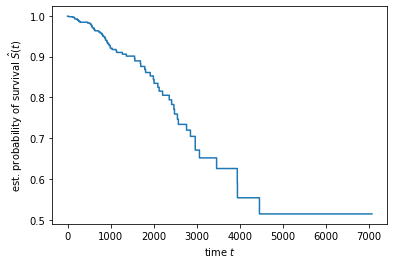

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

data_cox_1=data_cox

time, survival_prob = kaplan_meier_estimator(data_cox_1["vital_status_boolean"], data_cox_1["survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [ ]:
data_cox['tumor_status_imputed'].value_counts()

0    879
1     88
Name: tumor_status_imputed, dtype: int64

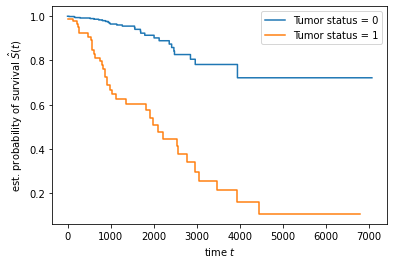

In [ ]:
# survival function by one parameter, two values 
for tumor_status in (0,1):
    mask_treat = data_cox_1["tumor_status_imputed"] == tumor_status
    time_tumor_status, survival_prob_tumor_status = kaplan_meier_estimator(
        data_cox_1["vital_status_boolean"][mask_treat],
        data_cox_1["survival_in_days"][mask_treat])

    plt.step(time_tumor_status, survival_prob_tumor_status, where="post",
             label="Tumor status = %s" % tumor_status)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [ ]:
data_cox['surgical_procedure_first'].value_counts()

Modified Radical Mastectomy    291
Other                          243
Lumpectomy                     239
Simple Mastectomy              194
Name: surgical_procedure_first, dtype: int64

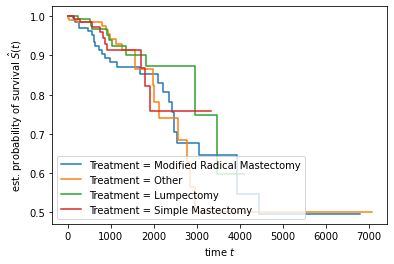

In [ ]:
for surgical_procedure in ("Modified Radical Mastectomy", "Other","Lumpectomy","Simple Mastectomy"):
    mask_treat = data_cox_1["surgical_procedure_first"] == surgical_procedure
    time_surgical_procedure, survival_prob_surgical_procedure = kaplan_meier_estimator(
        data_cox_1["vital_status_boolean"][mask_treat],
        data_cox_1["survival_in_days"][mask_treat])

    plt.step(time_surgical_procedure, survival_prob_surgical_procedure, where="post",
             label="Treatment = %s" % surgical_procedure)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

#PCOX data prep

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
data_y = data_cox[['vital_status_boolean','survival_in_days']].copy()
df_y=data_y
data_y["survival_in_days"] = data_y["survival_in_days"].astype('float')


In [ ]:
#data_y = data_y.to_records(column_dtypes={"vital_status_boolean":"?"},index=False)
data_y = data_y.to_records(index=False)

In [ ]:
saved_data_y=data_y

In [ ]:
data_x = data_cox.drop(['bcr_patient_uuid','bcr_patient_barcode','vital_status_boolean','survival_in_days','vital_status','last_contact_days_to','death_days_to',
                        'ajcc_tumor_pathologic_pt','ajcc_nodes_pathologic_pn','ajcc_metastasis_pathologic_pm','race_imputed',
                        'surgical_procedure_first','anatomic_neoplasm_subdivision','histological_type','icd_o_3_histology'],axis=1)

In [ ]:
saved_data_x=data_x

In [ ]:
x_p = data_x.drop(["age_at_diagnosis"],axis=1).astype("category")
x_p = OneHotEncoder().fit_transform(x_p)
x_p["age"] = data_x["age_at_diagnosis"]
data_x=x_p

In [ ]:
saved_data_x.to_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_x.csv")

#Multivariate Numerical (COX)

In [ ]:
#pd.Series(estimator_cox.coef_, index=saved_data_x.columns)

In [ ]:
#saved_data_x_int=saved_data_x.astype("int32")
#estimator_cox.score(saved_data_x_int, data_y)

In [ ]:
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

In [ ]:
y_for_split = df_y[['vital_status_boolean']].to_records(index= False)

In [ ]:
#not stratified
sum_test=0
sum_train=0
for i in range (42,47):
  x_train,x_test,y_train,y_test=train_test_split(
      saved_data_x,data_y,train_size=0.8,test_size=0.2,random_state=i)
  x_test = x_test.astype('int32')
  x_train = x_train.astype('int32')
  estimator_cox = CoxPHSurvivalAnalysis()
  estimator_cox.fit(x_train, y_train)
  prediction_cox = estimator_cox.predict(x_test)
  result_cox = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_cox)
  print("train_result:", estimator_cox.score(x_train, y_train))
  sum_train+=estimator_cox.score(x_train, y_train)
  print("test_result:", result_cox[0])
  sum_test+=result_cox[0]

print(sum_test/5)
print(sum_train/5)


train_result: 0.8846383741781231
test_result: 0.7654609101516919
train_result: 0.878512522907758
test_result: 0.7166979362101313
train_result: 0.8572002894588727
test_result: 0.8288543140028288
train_result: 0.8296336401371593
test_result: 0.9432355723746452
train_result: 0.8653803006506618
test_result: 0.8183716075156576
0.8145240680509909
0.8630730254665149


In [ ]:
x_train = x_train.astype('int32')
prediction_cox_tr = estimator_cox.predict(x_train)
result_cox_tr = concordance_index_censored(y_train["vital_status_boolean"], y_train["survival_in_days"], prediction_cox_tr)
result_cox_tr[0]

0.8653803006506618

In [ ]:
estimator_cox.score(x_train, y_train)

0.8653803006506618

In [ ]:
#stratified
sum_test=0
sum_train=0
for i in range (42,47):
  x_train,x_test,y_train,y_test=train_test_split(
      saved_data_x,data_y,train_size=0.8,test_size=0.2,random_state=i,stratify=y_for_split)
  x_test = x_test.astype('int32')
  x_train = x_train.astype('int32')
  estimator_cox = CoxPHSurvivalAnalysis()
  estimator_cox.fit(x_train, y_train)
  prediction_cox = estimator_cox.predict(x_test)
  result_cox = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_cox)
  print("train_result:", estimator_cox.score(x_train, y_train))
  sum_train+=estimator_cox.score(x_train, y_train)
  print("test_result:", result_cox[0])
  sum_test+=result_cox[0]

print("train_avg:",sum_train/5)

print("test_avg",sum_test/5)

train_result: 0.8291233283803864
test_result: 0.9464285714285714
train_result: 0.848697308058513
test_result: 0.9043570669500531
train_result: 0.8469395711500974
test_result: 0.9349593495934959
train_result: 0.8341467519353752
test_result: 0.9285714285714286
train_result: 0.8553339664450775
test_result: 0.8873668188736682
train_avg: 0.8428481851938899
test_avg 0.9203366470834435


In [ ]:
#stratified
x_train,x_test,y_train,y_test=train_test_split(
    saved_data_x,data_y,train_size=0.8,test_size=0.2,random_state=42, stratify=y_for_split)
x_test = x_test.astype('int32')
estimator_cox = CoxPHSurvivalAnalysis()
estimator_cox.fit(x_train, y_train)
prediction_cox = estimator_cox.predict(x_test)
result_cox = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_cox)
result_cox[0]

0.9296218487394958

In [ ]:
x_train = x_train.astype('int32')
prediction_cox_tr = estimator_cox.predict(x_train)
result_cox_tr = concordance_index_censored(y_train["vital_status_boolean"], y_train["survival_in_days"], prediction_cox_tr)
result_cox_tr[0]

0.8282492789091863

In [ ]:
estimator_cox.score(x_train, y_train)

0.8282492789091863

In [ ]:
#the StratifiedShuffleSplit does not allow specificication of y. Tough:(
''' 
cv_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=42)
x_int = saved_data_x.astype('int32')
#cross_val_score(estimator_cox, x_int, data_y, cv=cv_sss)
for train_index, test_index in cv_sss.split(saved_data_x, y_for_split):
  X_train, X_test = saved_data_x[train_index], saved_data_x[test_index]
  y_train, y_test = data_y[train_index], data_y[test_index]
  estimator_cox.fit(X_train, y_train)
  prediction_cox_this = estimator_cox.predict(X_test)
  result_cox = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_cox_this)
  print(result_cox[0])
'''

' \ncv_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=42)\nx_int = saved_data_x.astype(\'int32\')\n#cross_val_score(estimator_cox, x_int, data_y, cv=cv_sss)\nfor train_index, test_index in cv_sss.split(saved_data_x, y_for_split):\n  X_train, X_test = saved_data_x[train_index], saved_data_x[test_index]\n  y_train, y_test = data_y[train_index], data_y[test_index]\n  estimator_cox.fit(X_train, y_train)\n  prediction_cox_this = estimator_cox.predict(X_test)\n  result_cox = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_cox_this)\n  print(result_cox[0])\n'

In [ ]:
saved_data_x_int = saved_data_x.astype('int32')
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores_cox = fit_and_score_features(saved_data_x_int.values, data_y)
pd.Series(scores_cox, index=saved_data_x_int.columns).sort_values(ascending=False)

tumor_status_imputed          0.729663
pn                            0.685300
age_at_diagnosis              0.666545
tumor_stage                   0.640884
pt                            0.617107
pr_status_by_ihc_imputed      0.614648
er_status_by_ihc_imputed      0.604839
menopause_status_imputed      0.586529
pm                            0.555402
her2_status_by_ihc_imputed    0.544677
margin_status                 0.542794
history_other_malignancy      0.535025
dtype: float64

In [ ]:
pd.Series(estimator_cox.coef_, index=x_train.columns)

history_other_malignancy      1.431850
age_at_diagnosis              0.060628
margin_status                -0.298988
menopause_status_imputed     -0.257647
tumor_status_imputed          2.131279
er_status_by_ihc_imputed     -0.138592
pr_status_by_ihc_imputed     -1.384982
her2_status_by_ihc_imputed    0.198653
tumor_stage                  -0.220413
pt                            0.159945
pn                            0.330751
pm                           -1.140700
dtype: float64

#Penalized COX

In [ ]:
#################
# PENALIZED COX #
#################

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
Xt=saved_data_x
y=data_y

In [ ]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(15, 10))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

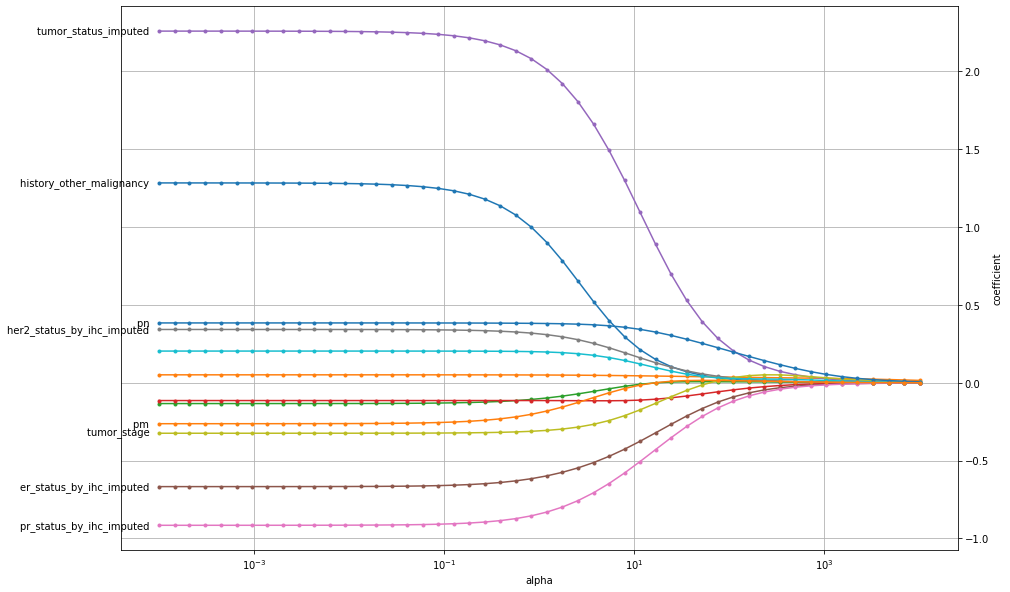

In [ ]:
plot_coefficients(coefficients, n_highlight=8)

In [ ]:
Xt_int = Xt.astype('int32')
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(Xt_int.values, data_y)
pd.Series(scores, index=Xt_int.columns).sort_values(ascending=False)

tumor_status_imputed          0.729663
pn                            0.685300
age_at_diagnosis              0.666545
tumor_stage                   0.640884
pt                            0.617107
pr_status_by_ihc_imputed      0.614648
er_status_by_ihc_imputed      0.604839
menopause_status_imputed      0.586529
pm                            0.555402
her2_status_by_ihc_imputed    0.544677
margin_status                 0.542794
history_other_malignancy      0.535025
dtype: float64

In [ ]:
pd.Series(estimator_cox.coef_, index=x_train.columns)

history_other_malignancy      1.431850
age_at_diagnosis              0.060628
margin_status                -0.298988
menopause_status_imputed     -0.257647
tumor_status_imputed          2.131279
er_status_by_ihc_imputed     -0.138592
pr_status_by_ihc_imputed     -1.384982
her2_status_by_ihc_imputed    0.198653
tumor_stage                  -0.220413
pt                            0.159945
pn                            0.330751
pm                           -1.140700
dtype: float64

#elastic net

In [ ]:
Xt=saved_data_x
y=data_y

In [ ]:
#not stratified
x_train,x_test,y_train,y_test=train_test_split(
    saved_data_x,data_y,train_size=0.8,test_size=0.2,random_state=42)
x_test = x_test.astype('int32')
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(x_train, y_train)
prediction_pcox_enet = cox_elastic_net.predict(x_test)
result_pcox_enet = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_pcox_enet)
result_pcox_enet[0]

0.7724620770128354

In [ ]:
#non-stratified 
#pcox test accuracy
#train with train and test with test
sum_test=0
sum_train=0
Xt=data_x
y=data_y
y_for_split = df_y[['vital_status_boolean']].to_records(index= False)
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
      Xt,y,train_size=0.8,test_size=0.2,random_state=i)
  cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
  cox_elastic_net.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction = cox_elastic_net.predict(x_test)
  result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
  result[0]
  print("tain_result:", cox_elastic_net.score(x_train, y_train))
  sum_train+= cox_elastic_net.score(x_train, y_train)
  print("test_result:", result[0])
  sum_test+=result[0]

print(sum_test/5)
print(sum_train/5)

tain_result: 0.8756297498078729
test_result: 0.7759626604434072
tain_result: 0.8539248625534515
test_result: 0.700750469043152
tain_result: 0.8444962611562273
test_result: 0.8161244695898161
tain_result: 0.8281447392167479
test_result: 0.9337748344370861
tain_result: 0.8602198788422706
test_result: 0.8674321503131524
0.8188089167653227
0.8524830983153141


In [ ]:
#stratified test accuracy multiple sampling 
sum_test=0
sum_train=0
Xt=saved_data_x
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
    Xt,y,train_size=0.8,test_size=0.2,random_state=i,stratify=y_for_split)
  cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
  cox_elastic_net.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction = cox_elastic_net.predict(x_test)
  result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
  result[0]
  print("tain_result:", cox_elastic_net.score(x_train, y_train))
  sum_train+=cox_elastic_net.score(x_train, y_train)
  print("test_result:", result[0])
  sum_test+=result[0]

print(sum_test/5)
print(sum_train/5)

tain_result: 0.8233983043440258
test_result: 0.9359243697478992
tain_result: 0.8489569808707695
test_result: 0.895855472901169
tain_result: 0.8497076023391813
test_result: 0.9365853658536586
tain_result: 0.839027263547627
test_result: 0.8934426229508197
tain_result: 0.8518914213358658
test_result: 0.8812785388127854
0.9086172740532664
0.8425963144874938


In [ ]:
#stratified
x_train,x_test,y_train,y_test=train_test_split(
    saved_data_x,data_y,train_size=0.8,test_size=0.2,random_state=42, stratify=y_for_split)
x_test = x_test.astype('int32')

In [ ]:
#stratified test accuracy for PCOX
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(x_train, y_train)
prediction_pcox_enet = cox_elastic_net.predict(x_test)
result_pcox_enet = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_pcox_enet)
result_pcox_enet[0]

0.9359243697478992

In [ ]:
#stratified train accuracy for PCOX 
cox_elastic_net.score(x_train, y_train)

0.8233983043440258

In [ ]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, alphas=None, copy_X=True,
                       fit_baseline_model=False, l1_ratio=0.9, max_iter=100000,
                       n_alphas=100, normalize=False, penalty_factor=None,
                       tol=1e-07, verbose=False)

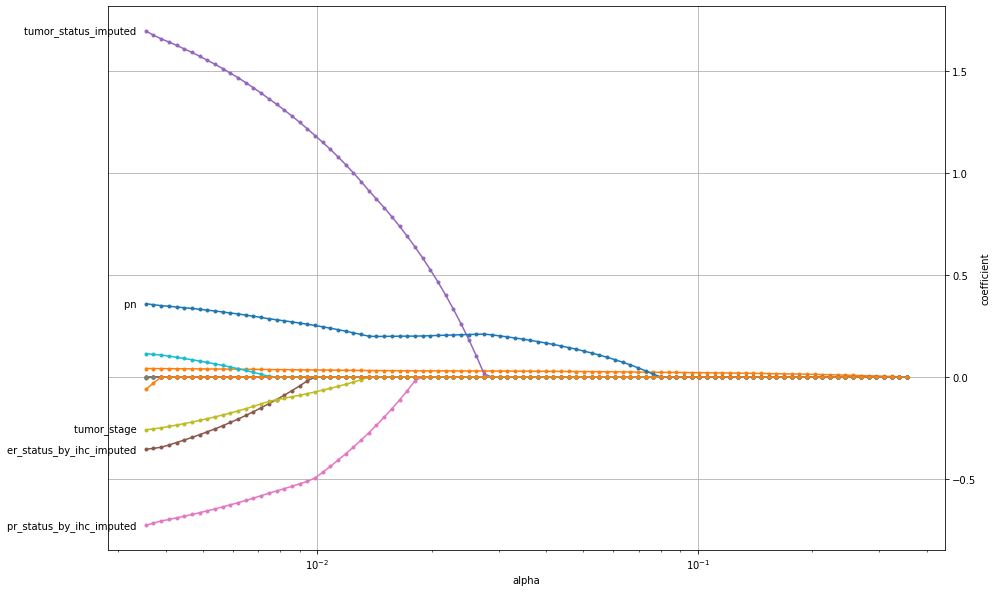

In [ ]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=Xt.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)